# 📘 Tutorial 3: Model Submission Template

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hypertrial/stacking_sats_challenge/blob/main/tutorials/3.%20Strategy%20Development%20Template.ipynb)

Welcome to the official submission template for the Stacking Sats Challenge.  
This notebook replicates the structure used by the evaluation engine to test all participant strategies.

---

## ✅ What You’ll Learn

By the end of this tutorial, you will:

- Understand the **boilerplate code** and what is already provided (e.g. imports, data loading, global config)
- Learn where and how to **insert your own strategy logic**
- Run **backtests and visualizations** to debug and assess performance
- Ensure your submission is **valid, testable, and reproducible**

---

## 🛠️ What You’re Expected to Do

- **Modify only the strategy function** inside the provided cell  
- Leave all boilerplate (e.g. registration, config, data loading) unchanged
- Submit your **dynamic_rule_causal** function for evaluation on [Hypertrial.ai]('https://www.hypertrial.ai/')

This structure guarantees consistency, fairness, and ease of comparison across all submitted models.

---

> ⚠️ Do not change function names, decorators, or global config values unless explicitly allowed.  
> Your entry must adhere to this template to be considered valid.


### 🚫 Boilerplate Code — Do Not Modify

In [3]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/config.py
# ---------------------------
BACKTEST_START = '2013-01-01'
BACKTEST_END = '2024-12-31'

MIN_WEIGHT = 1e-5

In [4]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# Extract BTC data from CoinMetrics and save locally
# ---------------------------
import pandas as pd 
import logging
from datetime import datetime

try:
    from coinmetrics.api_client import CoinMetricsClient
except ImportError:
    raise ImportError("coinmetrics.api_client module is required. Install it via pip:\n\n    pip install coinmetrics-api-client")

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

def extract_btc_data_to_csv(local_path='btc_price_data.csv'):
    client = CoinMetricsClient()
    asset = 'btc'
    metric = 'PriceUSD'
    start_time = '2010-01-01'
    end_time = datetime.today().strftime('%Y-%m-%d')
    frequency = '1d'

    logging.info(f"Fetching BTC data from {start_time} to {end_time}...")

    btc_df = client.get_asset_metrics(
        assets=asset,
        metrics=[metric],
        frequency=frequency,
        start_time=start_time,
        end_time=end_time
    ).to_dataframe()

    btc_df = btc_df.rename(columns={metric: 'Close'})
    btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()
    btc_df['time'] = btc_df['time'].dt.tz_localize(None)
    btc_df.set_index('time', inplace=True)
    btc_df = btc_df[['Close']]
    btc_df = btc_df.rename(columns={"Close": "btc_close"})

    btc_df.to_csv(local_path)
    logging.info(f"Saved BTC data to {local_path}")
    logging.info(f"Total records: {len(btc_df)}")
    logging.info(f"Date range: {btc_df.index.min()} to {btc_df.index.max()}")

    return btc_df

btc_df = extract_btc_data_to_csv("btc_price_data.csv")

2025-04-11 09:54:41 INFO     Fetching BTC data from 2010-01-01 to 2025-04-11...
2025-04-11 09:54:42 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-04-11 09:54:50 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-04-11 09:54:58 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-04-11 09:55:05 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-lim

In [5]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/data.py
# ---------------------------
import pandas as pd
import numpy as np
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

def load_data():
    df = pd.read_csv("btc_price_data.csv", index_col=0, parse_dates=True)
    df = df.rename(columns={"Close": "btc_close"})
    df = df.loc[~df.index.duplicated(keep='last')]
    df = df.sort_index()
    return df

def validate_price_data(df):
    if df.empty or 'btc_close' not in df.columns:
        raise ValueError("Invalid BTC price data.")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be datetime.")

In [20]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/spd.py (standalone notebook version)
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume these are defined in earlier cells
# from config cell: BACKTEST_START, BACKTEST_END
# from strategy registry cell: strategy_registry

def get_strategy(name):
    return strategy_registry[name]

def compute_cycle_spd(df, strategy_name):
    df_backtest = df.loc[BACKTEST_START:BACKTEST_END]
    cycle_length = pd.DateOffset(years=4)
    current = df_backtest.index.min()
    rows = []
    
    weight_fn = get_strategy(strategy_name)
    full_weights = weight_fn(df).fillna(0).clip(lower=0)
    inverted_prices = (1 / df_backtest['btc_close']) * 1e8

    while current <= df_backtest.index.max():
        cycle_end = current + cycle_length - pd.Timedelta(days=1)
        end_date = min(cycle_end, df_backtest.index.max())
        cycle_mask = (df_backtest.index >= current) & (df_backtest.index <= end_date)
        cycle = df_backtest.loc[cycle_mask]
        
        if cycle.empty:
            break

        cycle_label = f"{current.year}–{end_date.year}"
        cycle_prices = cycle['btc_close'].values
        high, low = np.max(cycle_prices), np.min(cycle_prices)
        min_spd = (1 / high) * 1e8
        max_spd = (1 / low) * 1e8

        cycle_inverted = inverted_prices.loc[cycle.index]
        w_slice = full_weights.loc[cycle.index]
        dynamic_spd = (w_slice * cycle_inverted).sum()
        uniform_spd = cycle_inverted.mean()

        spd_range = max_spd - min_spd
        uniform_pct = (uniform_spd - min_spd) / spd_range * 100
        dynamic_pct = (dynamic_spd - min_spd) / spd_range * 100
        excess_pct = dynamic_pct - uniform_pct

        rows.append({
            'cycle': cycle_label,
            'min_spd': min_spd,
            'max_spd': max_spd,
            'uniform_spd': uniform_spd,
            'dynamic_spd': dynamic_spd,
            'uniform_pct': uniform_pct,
            'dynamic_pct': dynamic_pct,
            'excess_pct': excess_pct
        })

        current += cycle_length

    return pd.DataFrame(rows).set_index('cycle')

def backtest_dynamic_dca(df, strategy_name="dynamic_dca"):
    df_res = compute_cycle_spd(df, strategy_name)
    
    dynamic_spd = df_res['dynamic_spd']
    dynamic_pct = df_res['dynamic_pct']
    
    dynamic_spd_metrics = {
        'min': dynamic_spd.min(),
        'max': dynamic_spd.max(),
        'mean': dynamic_spd.mean(),
        'median': dynamic_spd.median()
    }
    
    dynamic_pct_metrics = {
        'min': dynamic_pct.min(),
        'max': dynamic_pct.max(),
        'mean': dynamic_pct.mean(),
        'median': dynamic_pct.median()
    }

    print(f"\nAggregated Metrics for {strategy_name}:")
    print("Dynamic SPD:")
    for key, value in dynamic_spd_metrics.items():
        print(f"  {key}: {value:.2f}")
    print("Dynamic SPD Percentile:")
    for key, value in dynamic_pct_metrics.items():
        print(f"  {key}: {value:.2f}")

    print("\nExcess SPD Percentile Difference (Dynamic - Uniform) per Cycle:")
    for cycle, row in df_res.iterrows():
        print(f"  {cycle}: {row['excess_pct']:.2f}%")
    
    return df_res

def check_strategy_submission_ready(df, strategy_name):
    df_backtest = df.loc[BACKTEST_START:BACKTEST_END]
    cycle_length = pd.DateOffset(years=4)
    current = df_backtest.index.min()

    weight_fn = get_strategy(strategy_name)
    full_weights = weight_fn(df).fillna(0)

    passed = True

    while current <= df_backtest.index.max():
        cycle_end = current + cycle_length - pd.Timedelta(days=1)
        end_date = min(cycle_end, df_backtest.index.max())
        cycle_mask = (df_backtest.index >= current) & (df_backtest.index <= end_date)
        cycle = df_backtest.loc[cycle_mask]
        w_slice = full_weights.loc[cycle.index]

        cycle_label = f"{current.year}–{end_date.year}"

        # Criterion 1: strictly positive
        if (w_slice <= 0).any():
            print(f"[{cycle_label}] ❌ Some weights are zero or negative.")
            passed = False

        # Criterion 2: above minimum threshold
        if (w_slice < MIN_WEIGHT).any():
            print(f"[{cycle_label}] ❌ Some weights are below MIN_WEIGHT = {MIN_WEIGHT}.")
            passed = False

        # Criterion 3: weights must sum to 1 over the entire cycle
        total_weight = w_slice.sum().sum() if isinstance(w_slice, pd.DataFrame) else w_slice.sum()

        if not np.isclose(total_weight, 1.0, rtol=1e-5, atol=1e-8):
            print(f"[{cycle_label}] ❌ Total weights across the cycle do not sum to 1 (sum = {total_weight:.6f}).")
            passed = False

        current += cycle_length

    if passed:
        print("✅ Strategy is ready for submission.")
    else:
        print("⚠️ Fix the issues above before submission.")

def check_strategy_submission_ready(df, strategy_name):
    df_backtest = df.loc[BACKTEST_START:BACKTEST_END]
    cycle_length = pd.DateOffset(years=4)
    current = df_backtest.index.min()

    weight_fn = get_strategy(strategy_name)
    full_weights = weight_fn(df).fillna(0)

    passed = True

    while current <= df_backtest.index.max():
        cycle_end = current + cycle_length - pd.Timedelta(days=1)
        end_date = min(cycle_end, df_backtest.index.max())
        cycle_mask = (df_backtest.index >= current) & (df_backtest.index <= end_date)
        cycle = df_backtest.loc[cycle_mask]
        w_slice = full_weights.loc[cycle.index]

        cycle_label = f"{current.year}–{end_date.year}"

        # Criterion 1: strictly positive
        if (w_slice <= 0).any():
            print(f"[{cycle_label}] ❌ Some weights are zero or negative.")
            passed = False

        # Criterion 2: above minimum threshold
        if (w_slice < MIN_WEIGHT).any():
            print(f"[{cycle_label}] ❌ Some weights are below MIN_WEIGHT = {MIN_WEIGHT}.")
            passed = False

        # Criterion 3: weights must sum to 1 over the entire cycle
        total_weight = w_slice.sum().sum() if isinstance(w_slice, pd.DataFrame) else w_slice.sum()
        if not np.isclose(total_weight, 1.0, rtol=1e-5, atol=1e-8):
            print(f"[{cycle_label}] ❌ Total weights across the cycle do not sum to 1 (sum = {total_weight:.6f}).")
            passed = False

        current += cycle_length

    # Criterion 4: Dynamic SPD must be ≥ Uniform SPD for all cycles
    spd_results = compute_cycle_spd(df, strategy_name)
    for cycle, row in spd_results.iterrows():
        if row['dynamic_pct'] < row['uniform_pct']:
            print(f"[{cycle}] ❌ Dynamic SPD percentile ({row['dynamic_pct']:.2f}%) is less than uniform ({row['uniform_pct']:.2f}%).")
            passed = False

    if passed:
        print("✅ Strategy is ready for submission.")
    else:
        print("⚠️ Fix the issues above before submission.")


In [7]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/plots.py
# ---------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_price_vs_ma(df, weights=None):
    df = get_features()
    
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df['btc_close'], label='BTC Price', alpha=0.6)
    plt.plot(df.index, df['ma200'], label='MA200', alpha=0.9)

    signal = df['btc_close'] < df['ma200']
    plt.fill_between(df.index, df['btc_close'], df['ma200'], where=signal, color='green', alpha=0.1)

    if weights is not None:
        plt.scatter(df.index[~signal], df.loc[~signal, 'btc_close'], marker='o', facecolors='none', edgecolors='blue', label='Uniform')
        plt.scatter(df.index[signal], df.loc[signal, 'btc_close'], marker='o', color='red', label='Dynamic')

    plt.title("BTC Price vs MA200 (With Signal)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_final_weights(weights):
    start_year = pd.to_datetime(BACKTEST_START).year
    cycle_labels = weights.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)

    cmap = plt.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(12, 5))

    for cycle, group in weights.groupby(cycle_labels):
        label = f"{start_year + 4*cycle}–{start_year + 4*cycle + 3}"
        ax.plot(group.index, group.values, label=label, color=cmap(cycle % 10))

        uniform = 1.0 / len(group)
        ax.hlines(uniform, group.index.min(), group.index.max(), color=cmap(cycle % 10), linestyle='--', alpha=0.5)

    ax.set_title("Final Daily Weights")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_weight_sums_by_cycle(weights):
    start_year = pd.to_datetime(BACKTEST_START).year
    cycle_labels = weights.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)
    weight_sums = weights.groupby(cycle_labels).sum()
    
    print("Cycle Weight Sums:")
    for i, total in weight_sums.items():
        print(f"  {start_year + 4*i}–{start_year + 4*i + 3}: {total:.4f}")

    labels = [f"{start_year + 4*i}–{start_year + 4*i + 3}" for i in weight_sums.index]
    plt.bar(labels, weight_sums.values, alpha=0.7)
    plt.axhline(1.0, linestyle='--', color='black', label='Target: 1.0')
    plt.title("Weight Sums by Cycle")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_spd_comparison(df_res, strategy_name):
    x = np.arange(len(df_res.index))
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_yscale('log')
    
    lines = ax1.plot(
        x, df_res['min_spd'], 'o-',
        x, df_res['max_spd'], 'o-',
        x, df_res['uniform_spd'], 'o-',
        x, df_res['dynamic_spd'], 'o-'
    )
    
    ax1.set_title(f"Uniform vs {strategy_name} DCA (SPD)")
    ax1.set_ylabel('Sats per Dollar (Log Scale)')
    ax1.set_xlabel("Cycle")
    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax1.legend(lines, ['Min spd (High)', 'Max spd (Low)', 'Uniform DCA spd', f"{strategy_name} spd"], loc='upper left')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_res.index)

    ax2 = ax1.twinx()
    barw = 0.4
    bar1 = ax2.bar(x - barw/2, df_res['uniform_pct'], width=barw, alpha=0.3)
    bar2 = ax2.bar(x + barw/2, df_res['dynamic_pct'], width=barw, alpha=0.3)
    
    ax2.set_ylabel('SPD Percentile (%)')
    ax2.set_ylim(0, 100)
    ax2.legend([bar1, bar2], ['Uniform %', f"{strategy_name} %"], loc='upper right')

    plt.tight_layout()
    plt.show()

# ✍️ User Code — Implement Your Strategy Logic Below

In [9]:
# ---------------------------
# core/strategies/ user strategy
# ---------------------------
strategy_registry = {}

def register_strategy(name):
    def wrapper(fn):
        strategy_registry[name] = fn
        return fn
    return wrapper

def get_features():
    df = load_data()
    df['ma200'] = df['btc_close'].rolling(window=200, min_periods=1).mean()
    df['std200'] = df['btc_close'].rolling(window=200, min_periods=1).std()
    return df

@register_strategy("dynamic_rule_causal")
def dynamic_rule_causal(df):
    REBALANCE_WINDOW = 365 * 2
    ALPHA = 1.25
    
    df = get_features()
    df = df.loc[BACKTEST_START:BACKTEST_END]

    
    weights = pd.Series(index=df.index, dtype=float)
    start_year = pd.to_datetime(BACKTEST_START).year
    cycle_labels = df.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)

    for cycle, group in df.groupby(cycle_labels):
        N = len(group)
        base_weight = 1.0 / N
        temp_weights = np.full(N, base_weight)
        strategy_active = True

        for i in range(N):
            if not strategy_active:
                break
            price, ma, std = group['btc_close'].iloc[i], group['ma200'].iloc[i], group['std200'].iloc[i]
            if price < ma and std > 0:
                z = (ma - price) / std
                boost = 1 + ALPHA * z
                boosted = temp_weights[i] * boost
                excess = boosted - temp_weights[i]
                start_idx = max(N - REBALANCE_WINDOW, i + 1)
                if start_idx >= N:
                    continue
                idxs = np.arange(start_idx, N)
                reduction = excess / len(idxs)
                projected = temp_weights[idxs] - reduction
                if np.all(projected >= MIN_WEIGHT):
                    temp_weights[i] = boosted
                    temp_weights[idxs] -= reduction
                else:
                    strategy_active = False

        weights.loc[group.index] = temp_weights

    return weights

### 🚫 Boilerplate Code — Do Not Modify

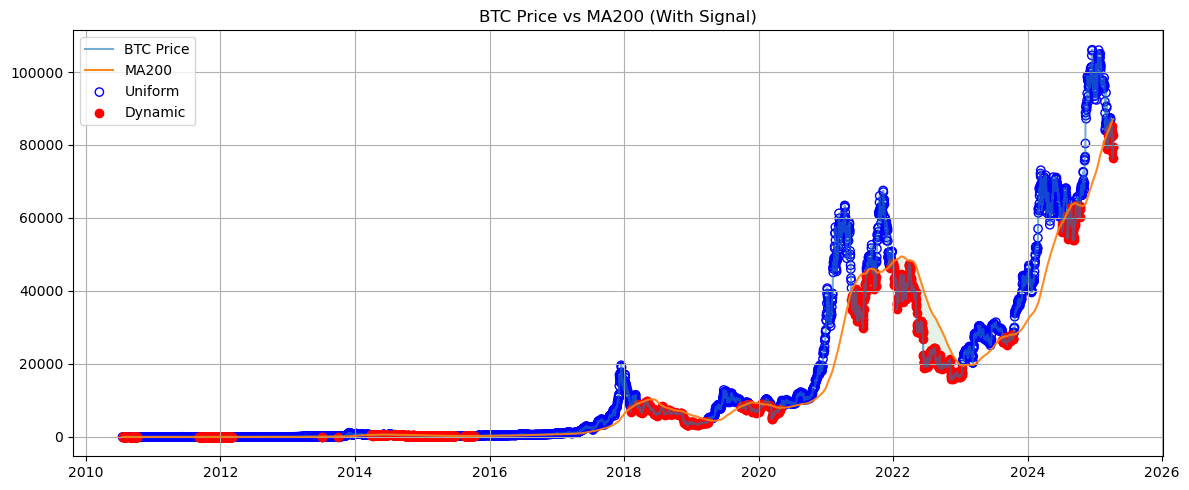

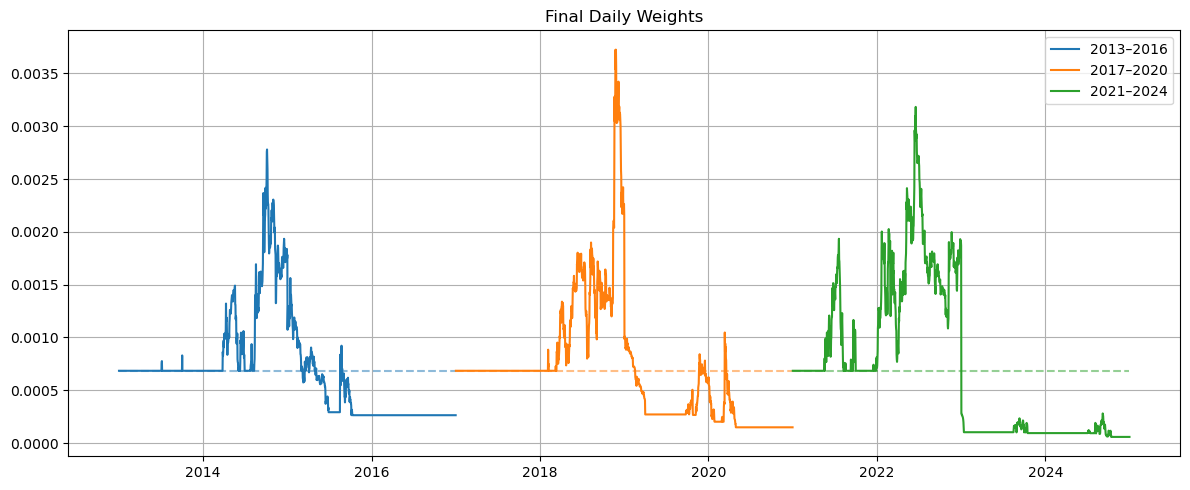

Cycle Weight Sums:
  2013–2016: 1.0000
  2017–2020: 1.0000
  2021–2024: 1.0000


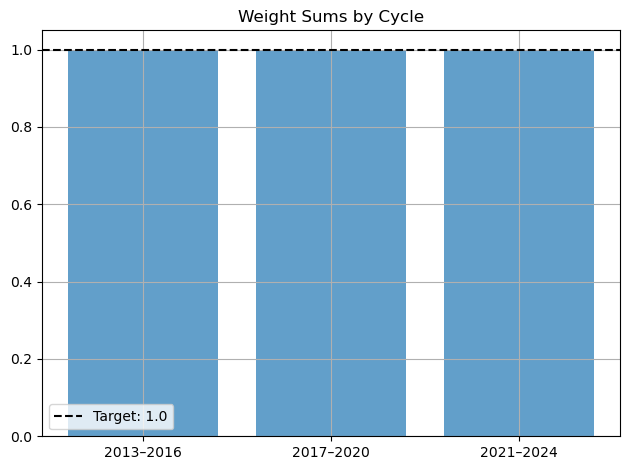


Aggregated Metrics for dynamic_rule_causal:
Dynamic SPD:
  min: 3490.17
  max: 596331.15
  mean: 208263.43
  median: 24968.98
Dynamic SPD Percentile:
  min: 6.83
  max: 47.15
  mean: 23.81
  median: 17.44

Excess SPD Percentile Difference (Dynamic - Uniform) per Cycle:
  2013–2016: 0.14%
  2017–2020: 1.94%
  2021–2024: 11.78%
✅ Strategy is ready for submission.


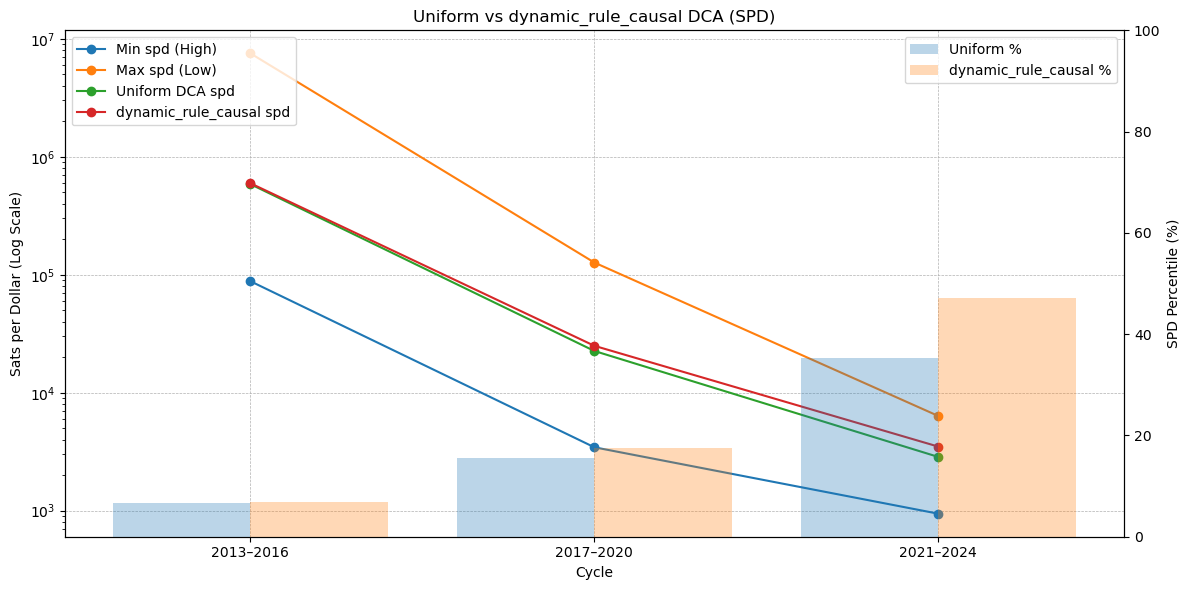

In [22]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# Run and visualize the strategy
# ---------------------------
btc_df = load_data()
validate_price_data(btc_df)
btc_df = btc_df.loc[BACKTEST_START:BACKTEST_END] # define truncated df with diff name 

strategy_name = "dynamic_rule_causal"
strategy_fn = strategy_registry[strategy_name]
weights = strategy_fn(btc_df)

plot_price_vs_ma(btc_df, weights) # need to revise to be plot_price_vs_feature
plot_final_weights(weights)  
plot_weight_sums_by_cycle(weights)

df_spd = backtest_dynamic_dca(btc_df, strategy_name="dynamic_rule_causal") # break into validate and get_stats
check_strategy_submission_ready(btc_df, strategy_name="dynamic_rule_causal")
plot_spd_comparison(df_spd, strategy_name="dynamic_rule_causal")